## Installation des packages

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np 
import scipy.stats as st


python -m jupyter nbconvert --to script TP_SRE.ipynb
à lancer pour convertir le markdoown en python (pour lancer le dash)

## Importation des données

In [3]:
def telecharger_donnees(ticker, start_date="1900-01-01"):
    """
    Télécharge les données boursières pour un ticker donné depuis Yahoo Finance.

    Paramètres :
    - ticker (str) : Le symbole boursier (ex: "^FCHI" pour le CAC 40).
    - start_date (str) : La date de début au format "YYYY-MM-DD".

    Retourne :
    - Un DataFrame contenant les données boursières.
    """
    data = yf.download(ticker, start=start_date)
    df = pd.DataFrame()
    df['Close'] = pd.DataFrame(data['Close'])
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    return df

'''
# Exemple d'utilisation :
df = telecharger_donnees("^FCHI", "2000-01-01")
print(df.head())
'''

'\n# Exemple d\'utilisation :\ndf = telecharger_donnees("^FCHI", "2000-01-01")\nprint(df.head())\n'

## Découpage apprentissage/test

Apprentissage : 15 octobre 2008 -26 juillet 2022 \\
Test : 27 juillet 2022 - 11 juin 2024

Histoire des taux avec la BCE
période de test : augmentation des taux

In [4]:
def split_train_test(df, train_start_date, train_end_date, test_start_date, test_end_date):
    """
    Divise les données en ensembles d'apprentissage et de test en fonction des dates spécifiées.

    Paramètres :
    - df : Le DataFrame contenant les données boursières (avec un index de dates).
    - train_start_date : La date de début de l'ensemble d'apprentissage (format "YYYY-MM-DD").
    - train_end_date : La date de fin de l'ensemble d'apprentissage (format "YYYY-MM-DD").
    - test_start_date : La date de début de l'ensemble de test (format "YYYY-MM-DD").
    - test_end_date : La date de fin de l'ensemble de test (format "YYYY-MM-DD").

    Retourne :
    - df_train : L'ensemble d'apprentissage.
    - df_test : L'ensemble de test.
    """
    # Découpage des données en fonction des dates
    df_train = df[(df.index >= train_start_date) & (df.index <= train_end_date)]
    df_test = df[(df.index >= test_start_date) & (df.index <= test_end_date)]

    return df_train, df_test

if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Effectuer la division train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Vérification
    print(f"Train data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")


Train data shape: (3523, 2)
Test data shape: (480, 2)


## Statistiques descriptives sur les 2 jeux de données

Statistiques descriptives du jeu de données d'apprentissage :
             Close  log_returns
count  3523.000000  3523.000000
mean   4601.299644     0.000153
std    1022.270616     0.013953
min    2519.290039    -0.130983
25%    3798.179932    -0.006099
50%    4463.000000     0.000580
75%    5318.609863     0.006855
max    7376.370117     0.096169

Statistiques descriptives du jeu de données de test :
             Close  log_returns
count   480.000000   480.000000
mean   7180.258167     0.000472
std     588.624058     0.008826
min    5676.870117    -0.036484
25%    6858.330200    -0.004104
50%    7260.850098     0.000760
75%    7491.614990     0.005526
max    8239.990234     0.041504


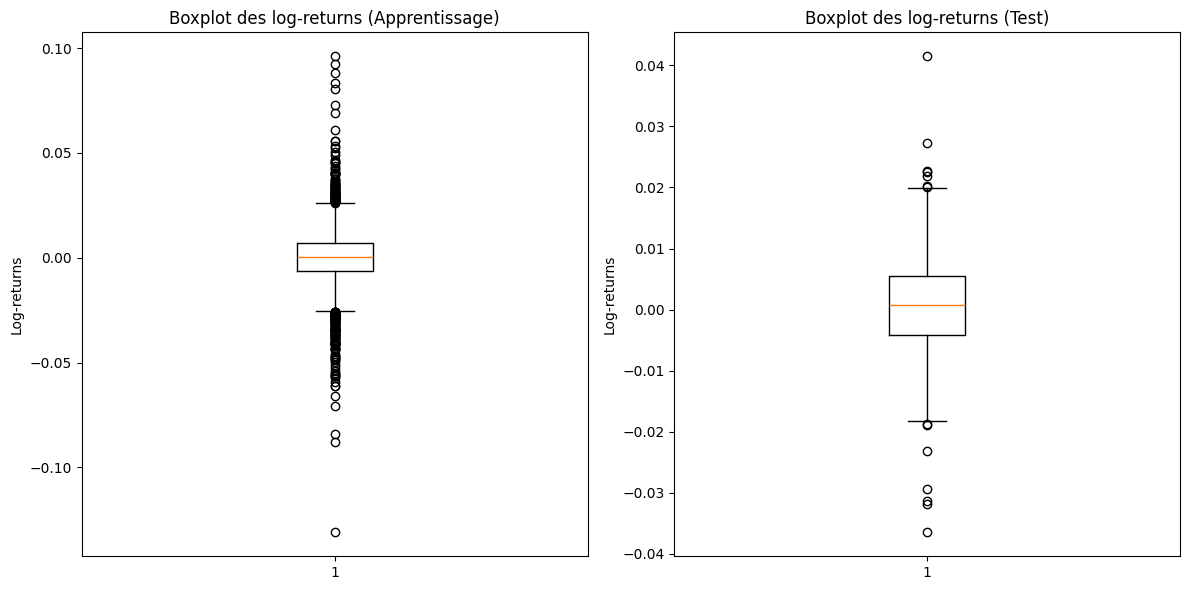

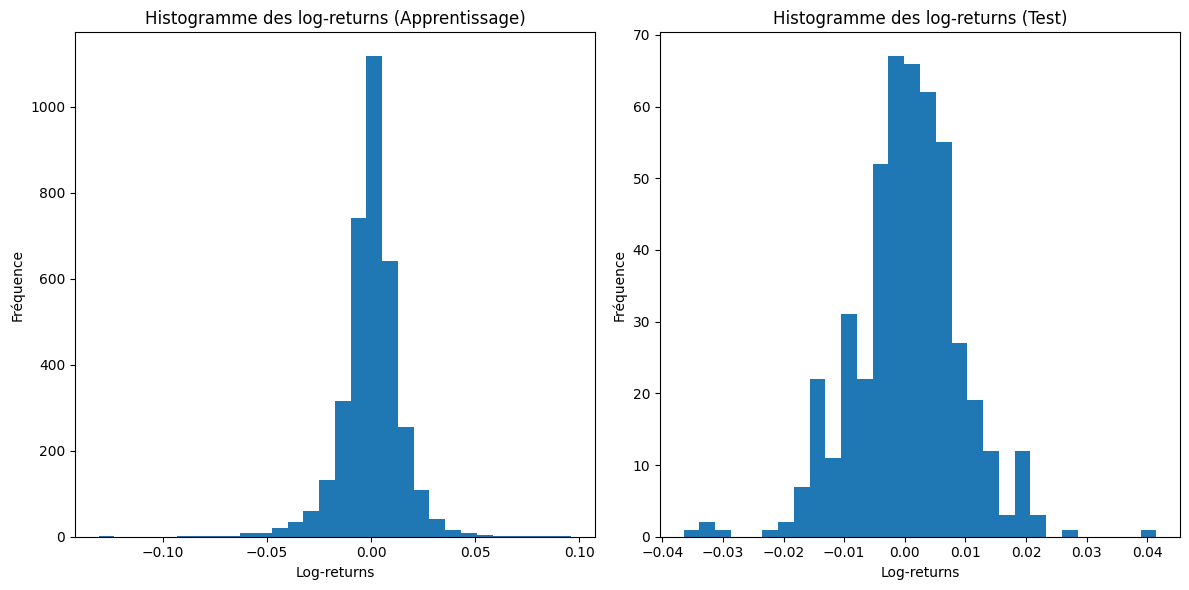

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_train_test_data(df_train, df_test):
    """
    Analyse les jeux de données d'apprentissage et de test :
    - Affiche les statistiques descriptives
    - Génère des boxplots des log-returns
    - Génère des histogrammes des log-returns

    Paramètres :
    - df_train : DataFrame du jeu de données d'apprentissage
    - df_test : DataFrame du jeu de données de test
    """

    # Statistiques descriptives
    print("Statistiques descriptives du jeu de données d'apprentissage :")
    print(df_train.describe())
    print("\nStatistiques descriptives du jeu de données de test :")
    print(df_test.describe())

    # Boxplots des log-returns
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(df_train['log_returns'].dropna())  
    plt.title("Boxplot des log-returns (Apprentissage)")
    plt.ylabel("Log-returns")

    plt.subplot(1, 2, 2)
    plt.boxplot(df_test['log_returns'].dropna())  
    plt.title("Boxplot des log-returns (Test)")
    plt.ylabel("Log-returns")

    plt.tight_layout()
    plt.show()

    # Histogrammes des log-returns
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_train['log_returns'].dropna(), bins=30)
    plt.title("Histogramme des log-returns (Apprentissage)")
    plt.xlabel("Log-returns")
    plt.ylabel("Fréquence")

    plt.subplot(1, 2, 2)
    plt.hist(df_test['log_returns'].dropna(), bins=30)
    plt.title("Histogramme des log-returns (Test)")
    plt.xlabel("Log-returns")
    plt.ylabel("Fréquence")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Analyse
    analyze_train_test_data(df_train, df_test)


## Graphique superposant les 2

On cherche ici à superoser le log-rendement et le prix de clôture sur un même graphique

In [6]:
import plotly.graph_objects as go
import pandas as pd

def plot_dual_axis_graph(df, ticker, train_start_date, train_end_date, test_start_date, test_end_date):
    """
    Génère un graphique Plotly avec deux axes Y :
    - Log-rendements en rouge (axe de gauche)
    - Prix de clôture en bleu (axe de droite)
    Le graphique est limité aux périodes entre le début du train et la fin du test.
    Des lignes pointillées indiquent les frontières des périodes d'entraînement et de test.

    Args:
        df (pd.DataFrame): Données avec 'Close' et 'log_returns'
        ticker (str): Symbole boursier
        train_start_date (str): Date de début de l'ensemble d'entraînement
        train_end_date (str): Date de fin de l'ensemble d'entraînement
        test_start_date (str): Date de début de l'ensemble de test
        test_end_date (str): Date de fin de l'ensemble de test
        
    Returns:
        fig (plotly.graph_objects.Figure): Graphique interactif
    """
    # Limiter le DataFrame aux dates d'entraînement et de test
    df_filtered = df[(df.index >= train_start_date) & (df.index <= test_end_date)]

    fig = go.Figure()

    # Log-rendements (rouge)
    fig.add_trace(go.Scatter(
        x=df_filtered.index, 
        y=df_filtered['log_returns'], 
        mode='lines', 
        name='Log-rendements', 
        line=dict(color='red')
    ))

    # Prix de clôture (bleu)
    fig.add_trace(go.Scatter(
        x=df_filtered.index, 
        y=df_filtered['Close'], 
        mode='lines', 
        name='Prix de clôture', 
        line=dict(color='blue'),
        yaxis="y2"
    ))

    # Ajouter des lignes pointillées pour les frontières des périodes
    fig.add_trace(go.Scatter(
        x=[train_start_date, train_start_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Début Train',
        line=dict(color='red', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=[train_end_date, train_end_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Fin Train',
        line=dict(color='red', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=[test_start_date, test_start_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Début Test',
        line=dict(color='green', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=[test_end_date, test_end_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Fin Test',
        line=dict(color='green', dash='dash')
    ))

    # Mise en forme des axes
    fig.update_layout(
        title=f"Log-rendements et Prix de clôture de {ticker}",
        xaxis=dict(title="Date"),
        yaxis=dict(title="Log-rendements", color="red"),
        yaxis2=dict(
            title="Prix de clôture",
            overlaying="y",
            side="right",
            color="blue"
        ),
        template="plotly_white"
    )

    return fig


if __name__ == "__main__":
    import plotly.io as pio

    # Télécharger les données du CAC 40 pour tester
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Définir les dates pour l'ensemble de train et de test
    train_start_date = "2008-10-15"
    train_end_date = "2022-07-26"
    test_start_date = "2022-07-27"
    test_end_date = "2024-06-11"

    # Générer le graphique
    fig = plot_dual_axis_graph(df, "^FCHI", train_start_date, train_end_date, test_start_date, test_end_date)

    # Afficher le graphique
    fig.show()  # Ouvre le graphique dans le navigateur ou l'affiche en ligne


# 1.VaR non paramétrique

## Question a.

Ecrire une fonction calculant la VaR historique (à 1 jour) d'un ensemble de log-rendements ==> VaR_Hist(x, alpha)

In [7]:
import numpy as np

def VaR_Hist(x, alpha):
    """
    Calcule la VaR historique (à 1 jour) d'un ensemble de log-rendements en utilisant np.percentile.

    Args:
        x: Une série Pandas de log-rendements.
        alpha: Le niveau de confiance (ex: 0.95 pour 95%).

    Returns:
        La VaR historique.
    """

    # Convertit alpha en pourcentage pour np.percentile
    percentile = (1 - alpha) * 100

    # Calcule la VaR avec np.percentile
    return np.percentile(x.dropna(), percentile)

## Question b

Calculer la VaR historique sur base d'apprentissage pour alpha=99%

In [8]:
if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR historique
    alpha = 0.99
    var_train = VaR_Hist(df_train['log_returns'], alpha)

    print(f"VaR historique (niveau de confiance {alpha*100:.0f}%) sur les données d'apprentissage : {var_train}")

VaR historique (niveau de confiance 99%) sur les données d'apprentissage : -0.04085030859377692


## Question c

Ecrire une fonction calculant la VaR historique bootstrap d'un ensemble de log-rendements et donnant un IC de niveau alpha_IC de cette VaR (VaR_Hist_Bootstrap(x,alpha, B, alpha_IC) )

In [9]:
def VaR_Hist_Bootstrap(x, alpha, B, alpha_IC):
    """
    Calcule la VaR historique bootstrap d'un ensemble de log-rendements et donne un intervalle de confiance.

    Args:
        x: Une série Pandas de log-rendements.
        alpha: Le niveau de confiance pour la VaR (par exemple, 0.95 pour un niveau de confiance de 95%).
        B: Le nombre de rééchantillonages bootstrap.
        alpha_IC: Le niveau de confiance pour l'intervalle de confiance (par exemple, 0.95 pour un intervalle de confiance de 95%).

    Returns:
        Un tuple contenant la VaR historique bootstrap, la borne inférieure de l'intervalle de confiance, et la borne supérieure de l'intervalle de confiance.
    """

    var_bootstrap = []
    for _ in range(B):
        # Échantillonnage bootstrap avec remise
        x_bootstrap = x.sample(n=len(x), replace=True)

        # Calcul de la VaR historique pour l'échantillon bootstrap
        var_bootstrap.append(VaR_Hist(x_bootstrap, alpha))

    # Calcul de la VaR bootstrap (moyenne des VaR des échantillons bootstrap)
    var_hist_bootstrap = np.mean(var_bootstrap)

    # Calcul de l'intervalle de confiance
    lower_bound = np.percentile(var_bootstrap, (1 - alpha_IC) / 2 * 100)
    upper_bound = np.percentile(var_bootstrap, (1 + alpha_IC) / 2 * 100)

    return var_hist_bootstrap, lower_bound, upper_bound


## Question d

Calculer la VaR historique Bootstrap et l'IC associé à 90% sur base d'apprentissage pour alpha = 99%

#refaire sous forme de graphique

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_var_bootstrap(x, alpha, alpha_IC, B_min=1000, B_max=10000, step=10):
    """
    Trace l'évolution de la VaR bootstrap en fonction des valeurs de B.

    Paramètres :
    - x : Les rendements (série de données).
    - alpha : Le niveau de confiance pour la VaR.
    - alpha_IC : Le niveau de confiance pour l'intervalle de confiance.
    - B_min, B_max, step : Les limites et le pas pour les valeurs de B à tester.
    """
    np.random.seed(42)
    B_values = np.arange(B_min, B_max, step)  # Ex: de 1000 à 10000 avec un pas de 20
    var_results = []

    # Calcul de la VaR bootstrap pour chaque valeur de B
    for B in B_values:
        var_bootstrap, _, _ = VaR_Hist_Bootstrap(x, alpha, B, alpha_IC)
        var_results.append(var_bootstrap)

    # Tracer l'évolution de la VaR bootstrap avec des points
    plt.figure(figsize=(10, 6))
    plt.plot(B_values, var_results, label="VaR bootstrap", marker='o', markersize=6, linestyle='-', color='blue')  # Ajout des points
    plt.xlabel("Nombre de simulations (B)")
    plt.ylabel("VaR bootstrap")
    plt.title("Évolution de la VaR bootstrap en fonction de B")
    plt.grid(True)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Tracer l'évolution de la VaR bootstrap
    plot_var_bootstrap(df_train['log_returns'], alpha=0.99, alpha_IC=0.90)

KeyboardInterrupt: 

In [11]:
if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Sélection manuelle de B optimal
    optimal_B = 8000  # Ajuster en fonction du graphique

    # Calcul final avec le B optimal sélectionné
    var_hist_bootstrap, lower_bound, upper_bound = VaR_Hist_Bootstrap(
        df_train['log_returns'], alpha=0.99, B=optimal_B, alpha_IC=0.90
    )

    # Affichage des résultats
    print(f"VaR historique bootstrap (niveau de confiance de 99%) : {var_hist_bootstrap}")
    print(f"Intervalle de confiance à 90% : [{lower_bound}, {upper_bound}]")


VaR historique bootstrap (niveau de confiance de 99%) : -0.04112204509653682
Intervalle de confiance à 90% : [-0.04385334557770063, -0.0383459972855314]


## Question e

Calculer le nombre d'exceptions sur la base de test associées à la VaR historique calculée en 1.b

In [12]:
def count_var_exceptions(df_test, var_value):
    """
    Compte le nombre d'exceptions où les log-rendements sont inférieurs à la VaR.

    Paramètres :
    - df_test : DataFrame contenant les rendements de test.
    - var_value : Valeur de la VaR calculée.

    Retourne :
    - Nombre d'exceptions.
    """
    exceptions = df_test[df_test['log_returns'] < var_value]
    return len(exceptions)

if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR sur les données d'apprentissage
    alpha = 0.99
    var_train = VaR_Hist(df_train['log_returns'], alpha)

    # Calcul des exceptions sur la période de test
    nb_exceptions = count_var_exceptions(df_test, var_train)

    # Affichage du résultat
    print(f"Nombre d'exceptions sur la période de test : {nb_exceptions}")


Nombre d'exceptions sur la période de test : 0


Résultat ok (voir l'histogramme sur l'ensemble test)

## Question f

Comparer statistiquement ce % d'exceptions avec le niveau de risque attendu (aide : on pourra par exemple passer par un IC de binomiale)


In [13]:
'''import scipy.stats as st

# Niveau de confiance pour l'intervalle de confiance de la proportion d'exceptions
alpha_IC_binomiale = 0.95

# Nombre d'observations dans le jeu de test
n = len(df_test)

# Niveau de risque attendu (1 - alpha)
niveau_risque_attendu = 1 - alpha

# Nombre d'exceptions observées
k = nb_exceptions

# Calcul de l'intervalle de confiance de la proportion d'exceptions
intervalle_confiance = st.binom.interval(alpha_IC_binomiale, n, niveau_risque_attendu)

# Affichage de l'intervalle de confiance
print(f"Intervalle de confiance à {alpha_IC_binomiale*100:.0f}% pour la proportion d'exceptions : [{intervalle_confiance[0]/n}, {intervalle_confiance[1]/n}]")
'''

'import scipy.stats as st\n\n# Niveau de confiance pour l\'intervalle de confiance de la proportion d\'exceptions\nalpha_IC_binomiale = 0.95\n\n# Nombre d\'observations dans le jeu de test\nn = len(df_test)\n\n# Niveau de risque attendu (1 - alpha)\nniveau_risque_attendu = 1 - alpha\n\n# Nombre d\'exceptions observées\nk = nb_exceptions\n\n# Calcul de l\'intervalle de confiance de la proportion d\'exceptions\nintervalle_confiance = st.binom.interval(alpha_IC_binomiale, n, niveau_risque_attendu)\n\n# Affichage de l\'intervalle de confiance\nprint(f"Intervalle de confiance à {alpha_IC_binomiale*100:.0f}% pour la proportion d\'exceptions : [{intervalle_confiance[0]/n}, {intervalle_confiance[1]/n}]")\n'

# 2.VaR gaussienne

## Question a

a.	Ecrire une fonction calculant la VaR gaussienne d’un ensemble de log-rendements (VaR_Gauss(x, alpha) )

In [14]:
def VaR_Gauss(x, alpha):
    """
    Calcule la VaR gaussienne (à 1 jour) d'un ensemble de log-rendements.

    Args:
        x: Une série Pandas de log-rendements.
        alpha: Le niveau de confiance (ex: 0.99 pour 99%).

    Returns:
        La VaR gaussienne.
    """
    # Calculer la moyenne et l'écart-type des log-rendements
    mu = np.mean(x.dropna())
    sigma = np.std(x.dropna())

    # Calculer le quantile correspondant au niveau de confiance alpha
    quantile = st.norm.ppf(1 - alpha)

    # Calculer la VaR gaussienne
    var_gauss = mu + sigma * quantile
    return var_gauss

## Question b

Calculer la VaR gaussienne sur base d’apprentissage pour alpha = 99%.

In [15]:
if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR gaussienne sur les données d'apprentissage
    alpha = 0.99
    var_gauss_train = VaR_Gauss(df_train['log_returns'], alpha)

    # Affichage du résultat
    print(f"VaR gaussienne (niveau de confiance de {alpha*100:.0f}%) sur les données d'apprentissage : {var_gauss_train}")

VaR gaussienne (niveau de confiance de 99%) sur les données d'apprentissage : -0.032301974025146105


## Question c

Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)

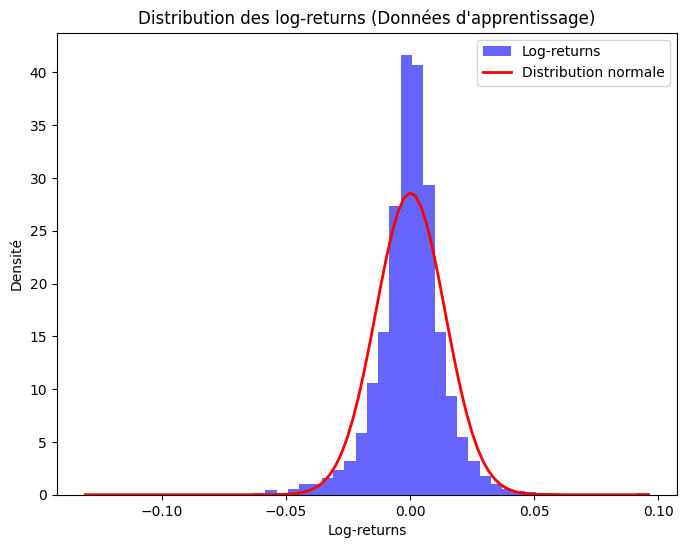

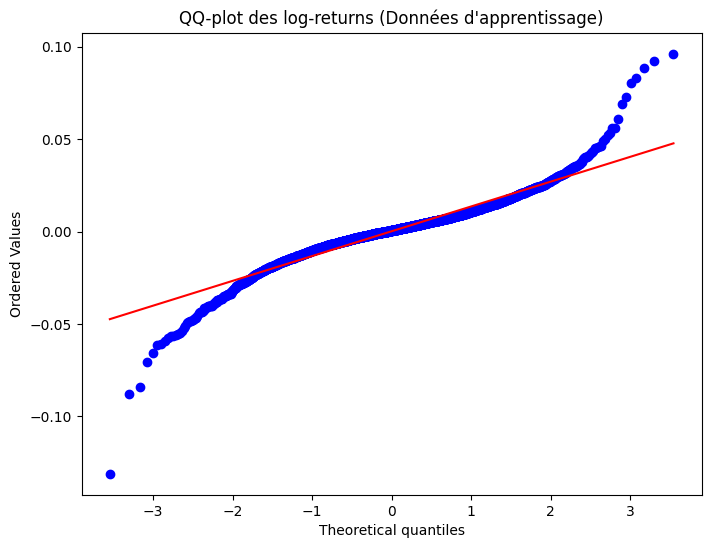

Test de Shapiro-Wilk: Statistique = 0.924, p-valeur = 0.000
On rejette l'hypothèse nulle: les données ne suivent pas une loi normale.


In [16]:
def analyze_log_returns(df_train):
    """
    Analyse graphique et statistique des log-returns :
    - Histogramme avec superposition de la loi normale
    - QQ-plot pour vérifier la normalité
    - Test de Shapiro-Wilk pour la normalité

    Args:
        df_train (pd.DataFrame): Données d'apprentissage avec colonne 'log_returns'
    """
    log_returns = df_train['log_returns'].dropna()

    # Histogramme avec densité normale
    plt.figure(figsize=(8, 6))
    plt.hist(log_returns, bins=50, density=True, alpha=0.6, color='b', label='Log-returns')
    plt.title('Distribution des log-returns (Données d\'apprentissage)')
    plt.xlabel('Log-returns')
    plt.ylabel('Densité')

    # Superposition de la loi normale
    mu, sigma = np.mean(log_returns), np.std(log_returns)
    x = np.linspace(min(log_returns), max(log_returns), 100)
    plt.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Distribution normale')
    plt.legend()
    plt.show()

    # QQ-plot
    plt.figure(figsize=(8, 6))
    st.probplot(log_returns, dist="norm", plot=plt)
    plt.title('QQ-plot des log-returns (Données d\'apprentissage)')
    plt.show()

    # Test de Shapiro-Wilk
    shapiro_test = st.shapiro(log_returns)
    print(f"Test de Shapiro-Wilk: Statistique = {shapiro_test[0]:.3f}, p-valeur = {shapiro_test[1]:.3f}")

    # Interprétation du test
    alpha_test = 0.05  # Seuil de signification
    if shapiro_test[1] < alpha_test:
        print("On rejette l'hypothèse nulle: les données ne suivent pas une loi normale.")
    else:
        print("On ne rejette pas l'hypothèse nulle: les données pourraient suivre une loi normale.")

if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Lancer l'analyse
    analyze_log_returns(df_train)

## Question d
Calculer la VaR gaussienne à 10j par la méthode du scaling

In [17]:
def VaR_Gauss_Scaling(var_gauss_1d, horizon=10):
    """
    Calcule la VaR gaussienne à un horizon de plusieurs jours en utilisant la méthode de scaling.

    Args:
        var_gauss_1d (float): VaR gaussienne à 1 jour.
        horizon (int): Nombre de jours pour la VaR (par défaut 10 jours).

    Returns:
        float: VaR gaussienne à l'horizon donné.
    """
    return np.sqrt(horizon) * var_gauss_1d

if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR gaussienne à 1 jour
    alpha = 0.99
    var_gauss_train = VaR_Gauss(df_train['log_returns'], alpha)

    # Calcul de la VaR gaussienne à 10 jours avec scaling
    var_gauss_10d = VaR_Gauss_Scaling(var_gauss_train, horizon=10)

    # Affichage des résultats
    print(f"VaR gaussienne à 1 jour (niveau de confiance {alpha*100:.0f}%) : {var_gauss_train}")
    print(f"VaR gaussienne à 10 jours (niveau de confiance {alpha*100:.0f}%) : {var_gauss_10d}")


VaR gaussienne à 1 jour (niveau de confiance 99%) : -0.032301974025146105
VaR gaussienne à 10 jours (niveau de confiance 99%) : -0.1021478108390588


## Question e

Calculer la VaR gaussienne à 10j par méthode de diffusion d’un actif.
dS=S.μ.dt + S.σ.Z.√dt       avec     Z ~N(0,1)
On pourra considérer :


*   S_0 comme la valeur du cours de clôture à la dernière date de l'échantillon d'apprentissage
*   dt=1jour
*   μ et σ les paramètres estimés en 2.b

In [18]:
def VaR_Gauss_Diffusion(S_0, mu, sigma, alpha, horizon=10, dt=1):
    """
    Calcule la VaR gaussienne à plusieurs jours en utilisant la méthode de diffusion.

    Args:
        S_0 (float): Dernier prix observé.
        mu (float): Espérance des log-rendements.
        sigma (float): Volatilité des log-rendements.
        alpha (float): Niveau de confiance (ex: 0.99 pour 99%).
        horizon (int): Nombre de jours pour la VaR (par défaut 10 jours).
        dt (float): Pas de temps (1 jour par défaut).

    Returns:
        float: VaR gaussienne par diffusion.
    """
    quantile_alpha = st.norm.ppf(1 - alpha)
    var_diffusion = np.exp((mu - 0.5 * sigma**2) * horizon * dt + sigma * np.sqrt(horizon * dt) * quantile_alpha) - 1
    return var_diffusion

if __name__ == "__main__":
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Récupération des paramètres
    S_0 = df_train['Close'].iloc[-1]
    mu = np.mean(df_train['log_returns'].dropna())
    sigma = np.std(df_train['log_returns'].dropna())
    alpha = 0.99
    horizon = 10

    # Calcul de la VaR par diffusion
    var_diffusion_10d = VaR_Gauss_Diffusion(S_0, mu, sigma, alpha, horizon)

    # Affichage des résultats
    print(f"VaR gaussienne à {horizon} jours (diffusion) : {var_diffusion_10d}")


VaR gaussienne à 10 jours (diffusion) : -0.09704050767925854


## Question f

In [19]:
import numpy as np
from scipy.stats import norm

def compute_EWMA_params(returns, lambd):
    """
    Calcule la moyenne et la variance pondérées EWMA.

    Paramètres :
        returns : np.array
            Série des rendements passés
        lambd : float
            Facteur d'lissage EWMA (ex: 0.94, 0.95, 0.99)

    Retour :
        mu_lambda : float
            Moyenne pondérée EWMA
        sigma_lambda : float
            Écart-type pondéré EWMA
    """
    T = len(returns)  # Taille de l'historique
    weights = np.array([(lambd**i) * (1 - lambd) for i in range(T)])  # Poids EWMA
    weights /= np.sum(weights)  # Normalisation des poids

    # Calcul de la moyenne pondérée exponentielle
    mu_ewma = np.sum(weights * returns[::-1])

    # Calcul de la variance pondérée exponentielle
    sigma_ewma = np.sqrt(np.sum(weights * (returns[::-1] - mu_ewma) ** 2))

    return mu_ewma, sigma_ewma

    return mu_lambda, sigma_lambda

def VaR_Gauss_EWMA(returns, alpha, lambd):
    """
    Calcule la VaR gaussienne à 1 jour en utilisant la méthode EWMA.

    Paramètres :
        returns : np.array
            Série des rendements passés
        alpha : float
            Niveau de confiance (ex: 0.99 pour 99%)
        lambd : float
            Facteur d'lissage EWMA (ex: 0.94, 0.95, 0.99)

    Retour :
        VaR : float
            La valeur à risque (VaR) estimée
    """
    mu_lambda, sigma_lambda = compute_EWMA_params(returns, lambd)
    VaR = mu_lambda + norm.ppf(alpha) * sigma_lambda  # Intégration de la moyenne EWMA
    return VaR


## Question g

In [20]:
def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Définition des paramètres
    lambdas = [0.9, 0.95, 0.99]
    alpha = 0.01  # Pour alpha = 99%, on utilise 0.01

    for lambd in lambdas:
        # i. Calculer les paramètres 𝜇̂(𝜆) et 𝜎̂2(𝜆)
        mu_lambda, sigma_lambda = compute_EWMA_params(df_train['log_returns'].values, lambd)
        print(f"Pour lambda = {lambd}:")
        print(f"  mu_hat(lambda) = {mu_lambda}")
        print(f"  sigma_hat(lambda) = {sigma_lambda}")

        # ii. Calculer la VaR gaussienne EWMA sur base d’apprentissage
        var_ewma = VaR_Gauss_EWMA(df_train['log_returns'].values, alpha, lambd)
        print(f"  VaR EWMA (alpha = {alpha}) = {var_ewma}")

        # iii. Calculer le nombre d’exceptions sur base de test
        exceptions = df_test[df_test['log_returns'] < var_ewma]
        nb_exceptions = len(exceptions)
        print(f"  Nombre d'exceptions sur la période de test : {nb_exceptions}")
        print("-" * 20)

if __name__ == "__main__":
    main()


Pour lambda = 0.9:
  mu_hat(lambda) = 0.0018981356545824813
  sigma_hat(lambda) = 0.011025314975193582
  VaR EWMA (alpha = 0.01) = -0.023750582398589754
  Nombre d'exceptions sur la période de test : 4
--------------------
Pour lambda = 0.95:
  mu_hat(lambda) = 0.0007351462996445099
  sigma_hat(lambda) = 0.012768499218598014
  VaR EWMA (alpha = 0.01) = -0.028968824712233117
  Nombre d'exceptions sur la période de test : 4
--------------------
Pour lambda = 0.99:
  mu_hat(lambda) = -0.00032061667697471074
  sigma_hat(lambda) = 0.014267240661065782
  VaR EWMA (alpha = 0.01) = -0.03351118165727413
  Nombre d'exceptions sur la période de test : 1
--------------------


# 3.VaR skew-Student


## Question a

Ecrire une fonction permettant d’estimer les paramètres d’une loi de Skew Student par maximum de vraisemblance.

On procédera par étapes : fonction de densité, fonction de log-vraisemblance, fonction d’optimisation.

On pourra utiliser le package scipy.optimize et la fonction minimize.

### Fonction de densité

In [21]:
from scipy.stats import t

def skew_student_pdf(x, mu, sigma, gamma, nu):
    """
    Fonction de densité de probabilité de la loi skew-Student.
    """
    z = (x - mu)/sigma
    # Calcul de la fonction de densité de la loi Student généralisée
    pdf_student = t.pdf(z, df=nu) / sigma  #t.pdf(x, df, loc, scale) is identically equivalent to t.pdf(y, df) / scale with y = (x - loc) / scale

    # Calcul de la fonction de répartition de la loi Student (nu + 1 degrés de liberté)
    cdf_student = st.t.cdf(gamma *z*np.sqrt((nu + 1)/(nu + z**2)), df=nu + 1)

    # Fonction de densité de la loi skew-Student
    pdf_skew_student = 2 * pdf_student * cdf_student

    return pdf_skew_student

### Fonction de log-vraisemblance

In [22]:
def log_likelihood_skew_student(params, x):
    """
    Fonction de log-vraisemblance pour la loi skew-student.
    """
    mu, sigma, gamma, nu = params

    # Vérification des contraintes sur les paramètres
    if sigma <= 0 or nu <= 0:
        return -np.inf  # Retourne -infini si les contraintes ne sont pas respectées

    log_likelihood = np.sum(np.log(skew_student_pdf(x, mu, sigma, gamma, nu)))
    return -log_likelihood  # On retourne l'opposé pour la minimisation

### Fonction d'optimisation

In [23]:
from scipy.optimize import minimize

def estimate_skew_student_params(x):
    """
    Estime les paramètres d'une loi skew-Student par maximum de vraisemblance.
    """

    # Initialisation des paramètres
    initial_params = [np.mean(x), np.std(x), 0, 5]  # Valeurs initiales pour mu, sigma, gamma, nu

    # Bornes des paramètres
    bounds = [(None, None), (1e-6, None), (None, None), (1e-6, None)] # sigma > 0, nu > 0

    # Optimisation
    result = minimize(log_likelihood_skew_student, initial_params, args=(x,), bounds=bounds)

    # Vérification de la convergence
    if not result.success:
        print(f"Optimization failed: {result.message}")
        return None

    return result.x

## Question b

Estimer les paramètres de loi Skew Student sur base d’apprentissage.

In [24]:
def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Estimation des paramètres de la loi Skew-Student sur les données d'apprentissage
    estimated_params = estimate_skew_student_params(df_train['log_returns'].dropna())

    if estimated_params is not None:
        mu_hat, sigma_hat, gamma_hat, nu_hat = estimated_params
        print(f"Paramètres estimés de la loi Skew-Student :")
        print(f"  mu_hat = {mu_hat}")
        print(f"  sigma_hat = {sigma_hat}")
        print(f"  gamma_hat = {gamma_hat}")
        print(f"  nu_hat = {nu_hat}")
    else:
        print("L'optimisation a échoué. Vérifiez les données ou les paramètres initiaux.")

if __name__ == "__main__":
    main()


Paramètres estimés de la loi Skew-Student :
  mu_hat = 0.002324665993313714
  sigma_hat = 0.008823907155806717
  gamma_hat = -0.2318222186309979
  nu_hat = 2.96188487460101


## Question c
Faire une validation ex-ante par QQ-plot.

In [25]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo

def inverse_cdf(var, p):
    """
    Trouve la valeur x telle que F(x) = p pour une distribution Skew-Student
    basée sur les paramètres estimés à partir des rendements var.

    Paramètres :
    - var : Une série de données (par exemple les rendements des actifs)
    - p : La probabilité à laquelle on veut inverser la CDF (entre 0 et 1)

    Retourne :
    - La valeur de x telle que F(x) = p
    """
    # Estimation des paramètres de la loi Skew-Student à partir des données var
    estimated_params = estimate_skew_student_params(var)

    if estimated_params is not None:
        mu_hat, sigma_hat, gamma_hat, nu_hat = estimated_params

        # Fonction de la CDF (intégrale de la PDF)
        def cdf(x):
            return spi.quad(lambda t: skew_student_pdf(t, mu_hat, sigma_hat, gamma_hat, nu_hat), -np.inf, x)[0]

        # Vérification que p est entre 0 et 1
        if not (0 < p < 1):
            raise ValueError("p doit être entre 0 et 1")

        # Trouver la valeur de x telle que F(x) = p
        return spo.root_scalar(lambda x: cdf(x) - p, bracket=[-5, 10]).root
    else:
        raise ValueError("Les paramètres estimés sont None.")

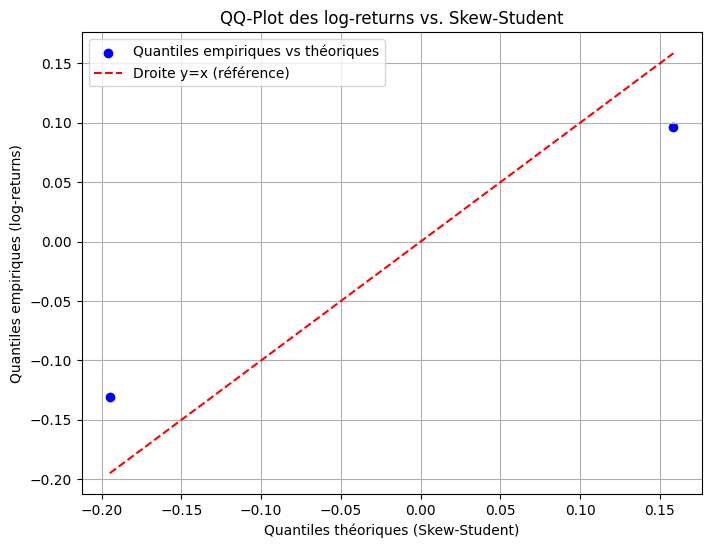

In [26]:
import scipy.integrate as spi
import scipy.optimize as spo


def plot_qq_skew_student(df_train):
    """
    Trace un QQ-Plot des log-returns par rapport à la loi Skew-Student estimée.

    Paramètres :
    - df_train : pd.DataFrame
        Les données d'entraînement, avec une colonne 'log_returns' contenant les rendements log.
    """
    # Extraire les données sans NaN
    log_returns = np.sort(df_train['log_returns'].dropna().values)
    n = len(log_returns)

    # Indices pour extraire des quantiles empiriques
    indices = np.linspace(0, len(log_returns) - 1, 2, dtype=int)
    quantiles_empiriques = log_returns[indices]

    # Calculer les probabilités associées aux quantiles empiriques
    p_vals = (indices + 0.5) / len(log_returns)  # Probabilités associées aux quantiles

    # Calculer les quantiles théoriques pour les probabilités données
    quantiles_theoriques = np.array([inverse_cdf(df_train['log_returns'], p) for p in p_vals])

    # Tracer le QQ-plot
    plt.figure(figsize=(8, 6))
    plt.scatter(quantiles_theoriques, quantiles_empiriques, color="blue", label="Quantiles empiriques vs théoriques")
    plt.plot(quantiles_theoriques, quantiles_theoriques, color="red", linestyle="--", label="Droite y=x (référence)")

    plt.xlabel("Quantiles théoriques (Skew-Student)")
    plt.ylabel("Quantiles empiriques (log-returns)")
    plt.title("QQ-Plot des log-returns vs. Skew-Student")
    plt.legend()
    plt.grid()
    plt.show()

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Tracer le QQ-Plot
    plot_qq_skew_student(df_train)

if __name__ == "__main__":
    main()

## Question d

Comparer la qualité de fit entre loi gaussienne et loi de skew Student par analyse graphique.

Paramètres estimés de la loi Skew-Student :
  mu_hat = 0.002324665993313714
  sigma_hat = 0.008823907155806717
  gamma_hat = -0.2318222186309979
  nu_hat = 2.96188487460101


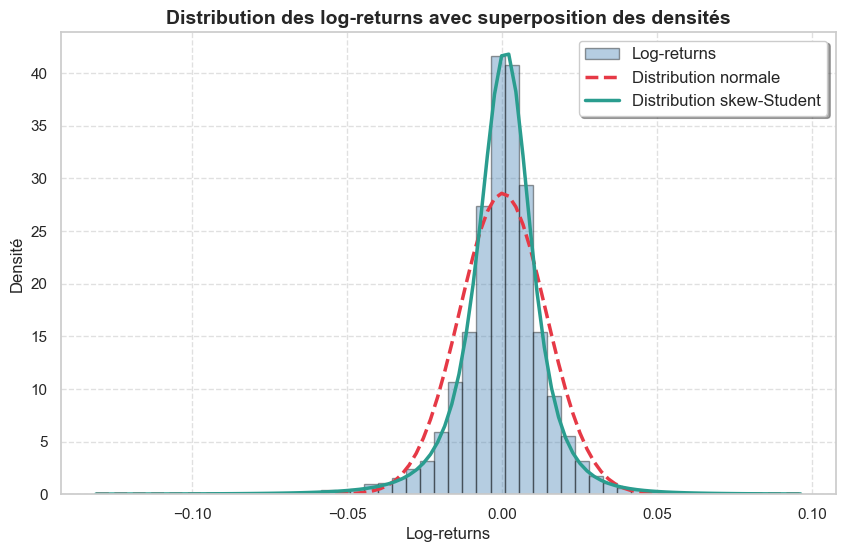

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

def plot_log_returns_distribution(df_train, mu_hat, sigma_hat, gamma_hat, nu_hat):
    """
    Trace l'histogramme des log-returns et superpose les densités de la loi normale et de la loi Skew-Student.

    Paramètres :
    - df_train : pd.DataFrame
        Les données d'entraînement contenant une colonne 'log_returns'.
    - mu_hat, sigma_hat, gamma_hat, nu_hat : float
        Paramètres estimés de la distribution Skew-Student.
    """
    # Appliquer un style seaborn
    sns.set(style="whitegrid")

    # Calcul de la moyenne et de l'écart-type pour la loi normale
    mu = np.mean(df_train['log_returns'].dropna())
    sigma = np.std(df_train['log_returns'].dropna())

    # Définition des valeurs de x pour les courbes de densité
    x = np.linspace(min(df_train['log_returns'].dropna()), max(df_train['log_returns'].dropna()), 100)

    # Création de la figure
    plt.figure(figsize=(10, 6))

    # Histogramme des log-returns
    plt.hist(df_train['log_returns'].dropna(), bins=50, density=True, alpha=0.4, 
             color='#4682B4', edgecolor='black', label='Log-returns')

    # Superposition de la densité normale
    plt.plot(x, st.norm.pdf(x, mu, sigma), color='#E63946', lw=2.5, linestyle='dashed', label='Distribution normale')

    # Superposition de la densité skew-student
    plt.plot(x, skew_student_pdf(x, mu_hat, sigma_hat, gamma_hat, nu_hat), color='#2A9D8F', lw=2.5, 
             label='Distribution skew-Student')

    # Ajout de la légende
    plt.legend(frameon=True, shadow=True, fontsize=12)

    # Titres et labels plus lisibles
    plt.title("Distribution des log-returns avec superposition des densités", fontsize=14, fontweight='bold')
    plt.xlabel("Log-returns", fontsize=12)
    plt.ylabel("Densité", fontsize=12)

    # Ajout d'une grille subtile
    plt.grid(True, linestyle="--", alpha=0.6)

    # Affichage du graphique
    plt.show()

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Estimation des paramètres de la loi Skew-Student
    estimated_params = estimate_skew_student_params(df_train['log_returns'].dropna())

    if estimated_params is not None:
        mu_hat, sigma_hat, gamma_hat, nu_hat = estimated_params
        print(f"Paramètres estimés de la loi Skew-Student :")
        print(f"  mu_hat = {mu_hat}")
        print(f"  sigma_hat = {sigma_hat}")
        print(f"  gamma_hat = {gamma_hat}")
        print(f"  nu_hat = {nu_hat}")

        # Tracer la distribution des log-returns avec les densités superposées
        plot_log_returns_distribution(df_train, mu_hat, sigma_hat, gamma_hat, nu_hat)
    else:
        print("L'optimisation a échoué. Vérifiez les données ou les paramètres initiaux.")

if __name__ == "__main__":
    main()


## Question e

Calculer la VaR Skew Student sur base d’apprentissage pour alpha = 99%.

In [28]:
def calculate_var_student(var, alpha=0.99):
    """
    Calcule la Value at Risk (VaR) basée sur la distribution Skew-Student
    pour un niveau de confiance donné.

    Paramètres :
    - df_train : pd.DataFrame
        Les données d'entraînement contenant une colonne 'log_returns'.
    - alpha : float (par défaut 0.99)
        Niveau de confiance pour la VaR (ex : 0.99 pour une VaR à 99%).

    Retourne :
    - La VaR calculée.
    """
    # Calcul de la VaR comme le quantile correspondant de la distribution Skew-Student
    VaR_student = inverse_cdf(var, 1 - alpha)
    return VaR_student

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR Skew-Student à 99% de confiance
    alpha = 0.99
    VaR_student_99 = calculate_var_student(df_train['log_returns'], alpha)

    # Affichage du résultat
    print(f"La VaR Skew-Student à {alpha * 100:.0f}% de confiance est : {VaR_student_99:.4f}")

if __name__ == "__main__":
    main()


La VaR Skew-Student à 99% de confiance est : -0.0426


# 4.Expected Shortfall

In [29]:
import numpy as np
import pandas as pd
import scipy.integrate as spi
import scipy.stats as st

# Fonction pour calculer l'ES empirique
def ES_empirique(x, VaR):
    """
    Calcule l'Expected Shortfall empirique en prenant la moyenne des rendements inférieurs à la VaR.

    Args:
        x: Une série Pandas de log-rendements.
        VaR: La valeur de la VaR associée à alpha.

    Returns:
        L'ES empirique.
    """
    log_returns_below_VaR = x[x < VaR]
    return log_returns_below_VaR.mean()

# Fonction pour calculer l'ES théorique à partir d'une distribution donnée
def ES_theorique(alpha, VaR, pdf_func):
    """
    Calcule l'Expected Shortfall théorique via l'intégrale de la densité.

    Args:
        alpha: Le niveau de confiance (par exemple, 0.01 pour 1%).
        VaR: La valeur de la VaR à partir de laquelle on calcule l'ES.
        pdf_func: La fonction de densité de probabilité (PDF) de la distribution.

    Returns:
        L'ES théorique.
    """
    def integrand(x):
        return x * pdf_func(x)

    integral_value, _ = spi.quad(integrand, -np.inf, VaR)
    return integral_value / (1 - alpha)

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Niveau de confiance
    alpha = 0.99

    # Calcul des VaR
    var_gauss = VaR_Gauss(df_train['log_returns'], alpha)
    var_hist = VaR_Hist(df_train['log_returns'], alpha)
    var_student = calculate_var_student(df_train['log_returns'], alpha)

    print(f"VaR Gaussienne (alpha = {alpha}) : {var_gauss:.4f}")
    print(f"VaR Historique (alpha = {alpha}) : {var_hist:.4f}")
    print(f"VaR Skew-Student (alpha = {alpha}) : {var_student:.4f}")

    # Calcul des ES empiriques
    es_emp_gauss = ES_empirique(df_train['log_returns'], var_gauss)
    es_emp_hist = ES_empirique(df_train['log_returns'], var_hist)
    es_emp_student = ES_empirique(df_train['log_returns'], var_student)

    print(f"ES empirique Gaussien (alpha = {alpha}) : {es_emp_gauss:.4f}")
    print(f"ES empirique Historique (alpha = {alpha}) : {es_emp_hist:.4f}")
    print(f"ES empirique Skew-Student (alpha = {alpha}) : {es_emp_student:.4f}")

    # Estimation des paramètres Skew-Student pour l'ES théorique
    mu_hat, sigma_hat, gamma_hat, nu_hat = estimate_skew_student_params(df_train['log_returns'].dropna())

    def pdf_gauss(x):
        return st.norm.pdf(x, loc=np.mean(df_train['log_returns']), scale=np.std(df_train['log_returns']))

    def pdf_skew_student(x):
        return skew_student_pdf(x, mu_hat, sigma_hat, gamma_hat, nu_hat)

    # Calcul des ES théoriques
    es_theo_gauss = ES_theorique(alpha, var_gauss, pdf_gauss)
    es_theo_student = ES_theorique(alpha, var_student, pdf_skew_student)

    print(f"ES théorique Gaussien (alpha = {alpha}) : {es_theo_gauss:.4f}")
    print(f"ES théorique Skew-Student (alpha = {alpha}) : {es_theo_student:.4f}")

if __name__ == "__main__":
    main()


VaR Gaussienne (alpha = 0.99) : -0.0323
VaR Historique (alpha = 0.99) : -0.0409
VaR Skew-Student (alpha = 0.99) : -0.0426
ES empirique Gaussien (alpha = 0.99) : -0.0447
ES empirique Historique (alpha = 0.99) : -0.0547
ES empirique Skew-Student (alpha = 0.99) : -0.0568
ES théorique Gaussien (alpha = 0.99) : -0.0370
ES théorique Skew-Student (alpha = 0.99) : -0.0671


# 5.Protocole de backtesting

In [30]:
#Cheryyyl je te laisse briller avec ton protocole mdrr 

# 6.VaR TVE : Approche Maxima par bloc

**Attention : la TVE s’intéresse aux queues de distribution droites (maximum, excès par valeurs supérieures). Penser à convertir les données avant de débuter.** \\
On pourra utiliser pour les VaR TVE les lois genextreme, gumbel_r et genpareto du package scipy.stats et les méthodes fit, pdf, ppf.

## Question a
Déterminer une taille de bloc s et construire un échantillon de maxima sur la base d’apprentissage.

In [39]:
import pandas as pd

def compute_block_maxima(df, freq='M'):
    """
    Calcule les maxima par bloc temporel sur les rendements logarithmiques négatifs.
    
    Args:
        df (pd.DataFrame): DataFrame contenant une colonne 'log_returns' et un index de dates.
        freq (str): Fréquence des blocs temporels (par défaut 'M' pour mois).
    
    Returns:
        pd.Series: Série des maxima par bloc temporel, avec les dates réelles des maxima.
    """
    # Créer une copie explicite pour éviter les warnings
    df_copy = df.copy()
    
    # Transformer en opposé pour inverser la queue de distribution
    df_copy['neg_log_returns'] = -df_copy['log_returns']
    
    # Définir des blocs temporels
    df_copy['block'] = df_copy.index.to_period(freq)
    
    # Trouver l'index (date réelle) du maximum dans chaque bloc
    block_maxima_dates = df_copy.groupby('block')['neg_log_returns'].idxmax()
    
    # Extraire les valeurs des maxima en utilisant les dates réelles
    block_maxima = df_copy.loc[block_maxima_dates, 'neg_log_returns']
    
    return block_maxima

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc
    block_maxima = compute_block_maxima(df_train)
    

if __name__ == "__main__":
    main()


In [41]:
import plotly.graph_objects as go
import pandas as pd

def plot_block_maxima(df, block_maxima):
    """
    Affiche un graphique des log-returns négatifs avec les block maxima.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les log-returns.
        block_maxima (pd.Series): Série des maxima par bloc temporel.
    
    Returns:
        go.Figure: Un graphique Plotly.
    """
    fig = go.Figure()
    
    # Tracer la série des log-returns négatifs (en gris pour le contexte)
    fig.add_trace(go.Scatter(
        x=df.index, y=-df['log_returns'], mode='lines', name='Log Returns inversés', line=dict(color='lightgray', width=1)
    ))
    
    # Tracer les block maxima en points rouges
    fig.add_trace(go.Scatter(
        x=block_maxima.index, y=block_maxima, mode='markers', name='Block Maxima (pertes extrêmes)', marker=dict(color='red', size=8)
    ))
    
    # Ajouter titres et légendes
    fig.update_layout(
        title="Block Maxima des Log-Returns (pertes extrêmes)",
        xaxis_title="Temps",
        yaxis_title="Pertes extrêmes (en valeur absolue)",
        legend=dict(x=0.02, y=0.98),
        xaxis=dict(showgrid=True),  # Activer la grille pour l'axe X
        yaxis=dict(showgrid=True)   # Activer la grille pour l'axe Y
    )
    
    return fig

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Calculer les maxima par bloc
    block_maxima = compute_block_maxima(df_train,"Y")

    print(block_maxima.head(5))
    
    # Créer le graphique avec la nouvelle fonction
    fig = plot_block_maxima(df_train, block_maxima)
    
    # Afficher le graphique avec plotly
    fig.show()

if __name__ == "__main__":
    main()

Date
2008-10-15    0.070633
2009-01-14    0.046694
2010-05-07    0.047074
2011-08-18    0.056346
2012-03-06    0.036494
Name: neg_log_returns, dtype: float64


## Question b
Tracer le Gumbel plot pour juger de l’hypothèse ξ=0 (i.e. GEV vs EV)

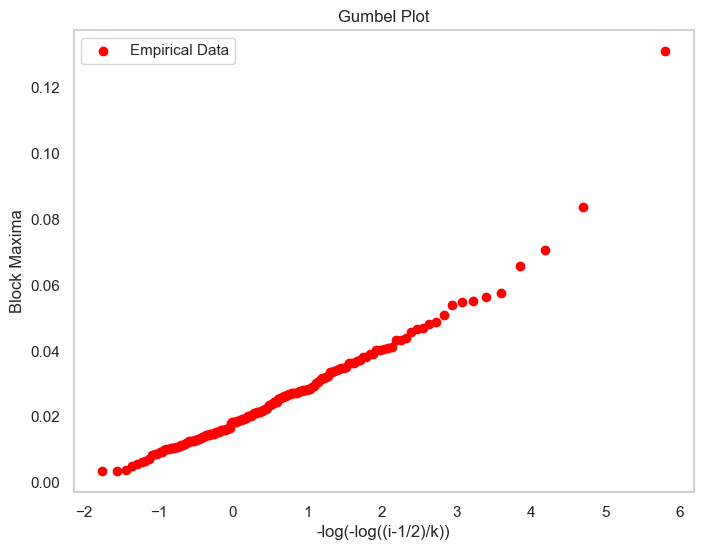

In [ ]:
def plot_gumbel(block_maxima):
    """
    Trace le Gumbel Plot pour visualiser l'ajustement aux distributions extrêmes.
    
    Args:
        block_maxima (pd.Series): Série des maxima par bloc temporel.
    """
    block_maxima = block_maxima.sort_values()
    k = len(block_maxima)
    
    # Calcul des coordonnées du Gumbel plot
    x_values = -np.log(-np.log((np.arange(1, k + 1) - 0.5) / k))
    y_values = block_maxima.values
    
    # Tracé du Gumbel plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, color="red", label="Empirical Data")
    plt.xlabel("-log(-log((i-1/2)/k))")
    plt.ylabel("Block Maxima")
    plt.title("Gumbel Plot")
    plt.legend()
    plt.grid()
    plt.show()

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc
    block_maxima = compute_block_maxima(df_train)
    
    # Afficher le Gumbel plot
    plot_gumbel(block_maxima)

if __name__ == "__main__":
    main()

#on peut aussi faire des tests genre vraisemblance après
#ou sur les intervalles de confiance

## Question c
Estimer les paramètres de loi GEV (ou EV si pertinent)


In [ ]:
# On utilise la loi GEV car la droite du Gumbel plot n'est pas forcément linéaire,
# ce qui suggère que ξ ≠ 0 et donc qu'une loi EV (Gumbel) simple n'est pas appropriée.

from scipy.stats import genextreme

def fit_gev(block_maxima):
    """
    Ajuste la loi GEV aux block maxima et affiche les paramètres estimés.
    
    Args:
        block_maxima (pd.Series): Série des maxima par bloc temporel.
    
    Returns:
        tuple: Paramètres estimés (shape c, location loc, scale scale).
    """
    params_gev = genextreme.fit(block_maxima)
    c, loc, scale = params_gev
    
    return c, loc, scale

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Calculer les maxima par bloc sur df_train
    block_maxima = compute_block_maxima(df_train)
    
    # Ajuster la loi GEV
    c,loc,scale = fit_gev(block_maxima)
    print(f"Paramètres GEV estimés (c, loc, scale): ({c}, {loc}, {scale})")

if __name__ == "__main__":
    main()


Paramètres GEV estimés (c, loc, scale): (-0.13418815042297177, 0.018000267015993266, 0.010002404066454567)


## Question d
Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)

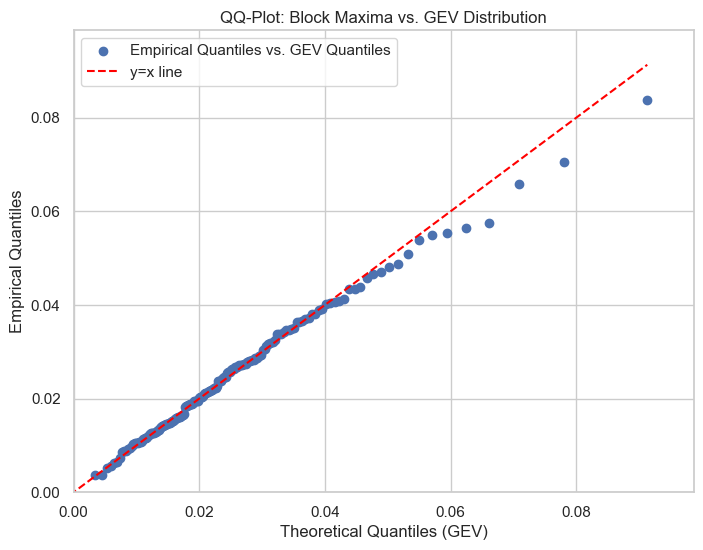

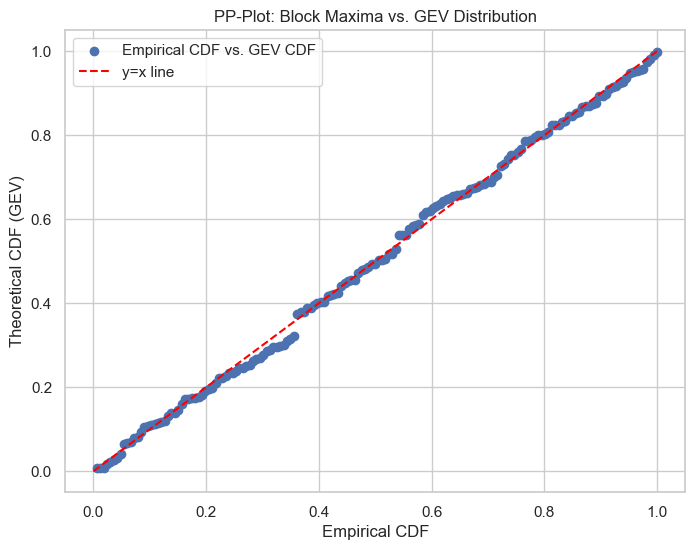

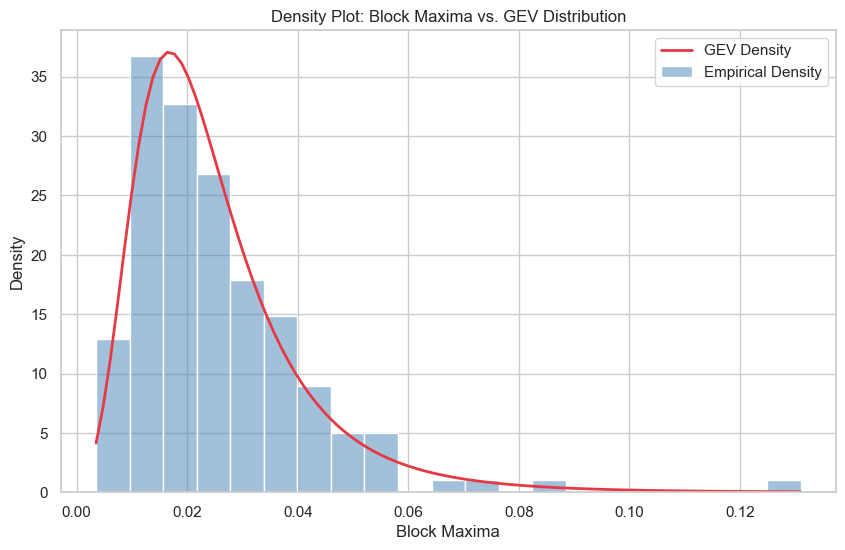

In [ ]:
def plot_gev_diagnostics(block_maxima, c, loc, scale):
    """
    Génère les graphiques QQ-plot, PP-plot et densité pour comparer les block maxima à la distribution GEV.
    
    Args:
        block_maxima (pd.Series): Série des maxima par bloc temporel.
        c (float): Paramètre de forme de la distribution GEV.
        loc (float): Paramètre de localisation de la distribution GEV.
        scale (float): Paramètre d'échelle de la distribution GEV.
    """
    # QQ-plot
    quantiles_gev = genextreme.ppf(np.linspace(0, 1, len(block_maxima)), c, loc=loc, scale=scale)
    plt.figure(figsize=(8, 6))
    plt.scatter(quantiles_gev, np.sort(block_maxima), label='Empirical Quantiles vs. GEV Quantiles')
    plt.plot(quantiles_gev, quantiles_gev, color='red', linestyle='--', label='y=x line')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.title('QQ-Plot: Block Maxima vs. GEV Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # PP-plot
    ecdf = np.arange(1, len(block_maxima) + 1) / len(block_maxima)
    cdf_gev = genextreme.cdf(np.sort(block_maxima), c, loc=loc, scale=scale)
    plt.figure(figsize=(8, 6))
    plt.scatter(ecdf, cdf_gev, label='Empirical CDF vs. GEV CDF')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y=x line')
    plt.xlabel('Empirical CDF')
    plt.ylabel('Theoretical CDF (GEV)')
    plt.title('PP-Plot: Block Maxima vs. GEV Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Density plot
    x = np.linspace(min(block_maxima), max(block_maxima), 100)
    density_gev = genextreme.pdf(x, c, loc=loc, scale=scale)
    plt.figure(figsize=(10, 6))
    sns.histplot(block_maxima, stat='density', kde=False, label='Empirical Density', color='#4682B4', alpha=0.5)
    plt.plot(x, density_gev, color='#E63946', lw=2, label='GEV Density')
    plt.xlabel('Block Maxima')
    plt.ylabel('Density')
    plt.title('Density Plot: Block Maxima vs. GEV Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Calculer les maxima par bloc sur df_train
    block_maxima = compute_block_maxima(df_train)
    
    # Ajuster la loi GEV
    c, loc, scale = fit_gev(block_maxima)
    
    # Tracer les diagnostics
    plot_gev_diagnostics(block_maxima, c, loc, scale)

if __name__ == "__main__":
    main()

#commentaire du prof :
#les graphes sont vrmt pas mal car on regarde la queue de distribution d'une queue de distribution

## Question e
Calculer la VaR TVE par MB sur base d’apprentissage pour alpha = 99% \\
Attention :  $$ 𝜶(𝑩𝑴) =𝜶^s $$

In [ ]:
from scipy.stats import genextreme

def compute_var_tve(alpha, c, loc, scale, freq='M'):
    """
    Calcule la Value at Risk (VaR) basée sur la distribution GEV (Generalized Extreme Value).
    
    Args:
        alpha (float): Le niveau de confiance (par exemple, 0.99 pour un niveau de 99%).
        c (float): Paramètre de forme de la distribution GEV.
        loc (float): Paramètre de localisation de la distribution GEV.
        scale (float): Paramètre d'échelle de la distribution GEV.
        freq (str): Fréquence des blocs temporels ('M' pour mois, 'Q' pour trimestre, 'Y' pour année).
        
    Returns:
        float: La VaR calculée à partir de la distribution GEV.
    """
    # Définir l'exposant en fonction de la fréquence
    if freq == 'M':  # Mensuel
        exponent = 21  # ~21 jours ouvrés par mois
    elif freq == 'Q':  # Trimestriel
        exponent = 63  # ~63 jours ouvrés par trimestre (21 jours/mois * 3 mois)
    elif freq == 'Y':  # Annuel
        exponent = 252  # ~252 jours ouvrés par an (21 jours/mois * 12 mois)
    else:
        raise ValueError("Fréquence non reconnue. Utilisez 'M' (mois), 'Q' (trimestre) ou 'Y' (année).")
    
    # Calcul de alpha_bm en fonction de la fréquence
    alpha_bm = alpha**exponent
    
    # Calcul de la VaR via la fonction quantile de la distribution GEV
    var_tve = genextreme.ppf(alpha_bm, c=c, loc=loc, scale=scale)
    
    # On prend l'opposé pour revenir aux rendements initiaux
    return -var_tve


def main():
    # Charger les données
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Calculer les maxima par bloc sur df_train
    block_maxima = compute_block_maxima(df_train)
    
    # Ajuster la loi GEV
    c, loc, scale = fit_gev(block_maxima)
    
    # Calculer la VaR TVE
    alpha = 0.99
    var_tve = compute_var_tve(alpha, c, loc, scale)
    
    print(f"La VaR TVE à {alpha*100}% de confiance est : {var_tve:.4f}")

if __name__ == "__main__":
    main()

La VaR TVE à 99.0% de confiance est : -0.0353


# 7.VaR TVE : Approche Peak over threshold

## Question a
Ecrire une fonction permettant d’obtenir le mean excess plot

In [ ]:
import matplotlib.pyplot as plt

def mean_excess_plot(data, threshold_values):
    """
    Generates a mean excess plot for a given dataset and range of thresholds.

    Args:
        data: A 1D numpy array or pandas Series of data values.
        threshold_values: A 1D numpy array or list of threshold values.

    Returns:
        A tuple containing two lists: mean excesses and the corresponding threshold values.
    """

    mean_excesses = []
    for threshold in threshold_values:
        exceedances = data[data > threshold] - threshold
        if exceedances.size > 0 :
          mean_excess = exceedances.mean()
        else:
          mean_excess = np.nan  # Handle cases with no exceedances
        mean_excesses.append(mean_excess)

    return mean_excesses, threshold_values

## Question b
Déterminer u par analyse graphique. \\
*Attention : ne pas considérer ni les valeurs négatives de u, ni les valeurs trop extrêmes, au risque d’écraser l’échelle visuelle du graphique.*


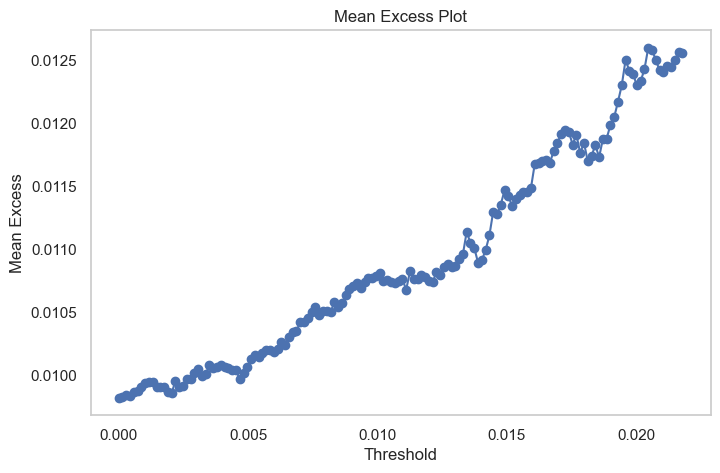

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_mean_excess(df, quantile_plot):
    """
    Calcule et trace le Mean Excess Plot pour les rendements négatifs.
    
    Args:
        df (pd.DataFrame): Le DataFrame contenant les rendements.
        quantile_plot (float) : quantile à partir duquel nous tronquons les données pour l'affichage du graphique 
        
    Affiche:
        Un graphique du Mean Excess Plot pour les rendements négatifs.
    """
    # Créer une copie du DataFrame et inverser les rendements négatifs
    df_copy = df.copy()
    df_copy['neg_log_returns'] = -df_copy['log_returns']  # Inverser les rendements

    quantile_percent = df_copy['neg_log_returns'].quantile(quantile_plot)

    # Définir un ensemble de valeurs seuils
    threshold_values = np.linspace(max(df_copy['neg_log_returns'].min(), 0), min(quantile_percent, df_copy['neg_log_returns'].max()), 150)

    # Calculer les excès moyens
    mean_excesses, thresholds = mean_excess_plot(df_copy['neg_log_returns'], threshold_values)

    # Tracer le Mean Excess Plot
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_excesses, marker='o', linestyle='-')
    plt.xlabel('Threshold')
    plt.ylabel('Mean Excess')
    plt.title('Mean Excess Plot')
    plt.grid()
    plt.show()

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    quantile_plot = 0.95

    # Appeler la fonction pour générer et afficher le Mean Excess Plot
    plot_mean_excess(df_train, quantile_plot)

if __name__ == "__main__":
    main()
 


# dire qu'au delà de 0.04, on est déjà sur les queues de distribution
#pour la justification, on peut calculer le quantile à 5% par exemple


#faire des fonctions linéaires par morceaux ?

In [ ]:
'''plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['neg_log_returns'])
plt.axhline(y=0.012, color='r', linestyle='--', label='u = 0.012')
plt.xlabel('Time')
plt.ylabel('neg_log_returns')
plt.title('Time Series of neg_log_returns with Horizontal Line at u = 0.012')
plt.legend()
plt.grid(True)
plt.show()
'''

## Question c
Estimer les paramètres de loi GPD

In [ ]:
from scipy.stats import genpareto
import pandas as pd

def fit_gpd_to_exceedances(df, threshold):
    """
    Ajuste la distribution de Pareto généralisée (GPD) sur les excès au-dessus du seuil spécifié.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les rendements log.
        threshold (float): Le seuil au-dessus duquel on calcule les excès.
        
    Returns:
        tuple: Les paramètres estimés de la GPD (c, loc, scale).
    """
    # Filtrer les excès au-dessus du seuil
    exceedances = df['neg_log_returns'][df['neg_log_returns'] > threshold] - threshold

    # Ajuster la distribution de Pareto généralisée (GPD) sur les excès
    params_gpd = genpareto.fit(exceedances)

    # Extraire les paramètres ajustés
    c, loc, scale = params_gpd

    return c, loc, scale

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    df['neg_log_returns'] = -df['log_returns'] 
    
    # Découper les données en train/test (exemple, à adapter selon tes besoins)
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Définir le seuil (u) pour l'ajustement GPD
    threshold = 0.012
    
    # Appeler la fonction pour ajuster la GPD sur les excès
    c, loc, scale = fit_gpd_to_exceedances(df_train, threshold)
    
    print(f"Les paramètres estimés de la GPD (c, loc, scale) sont : ({c}, {loc}, {scale})")

if __name__ == "__main__":
    main()


Les paramètres estimés de la GPD (c, loc, scale) sont : (0.13421790237448972, 1.2874483875162915e-05, 0.009290152910753843)


## Question d
Faire une validation ex-ante (analyse graphiques, QQ-plot, etc.)

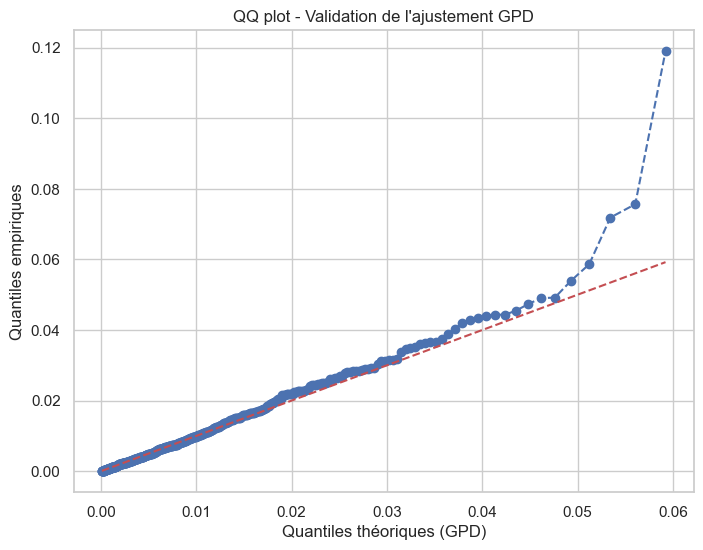

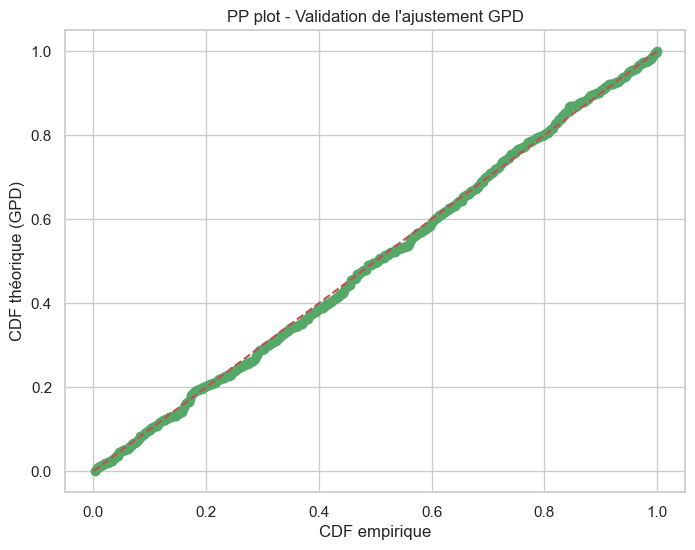

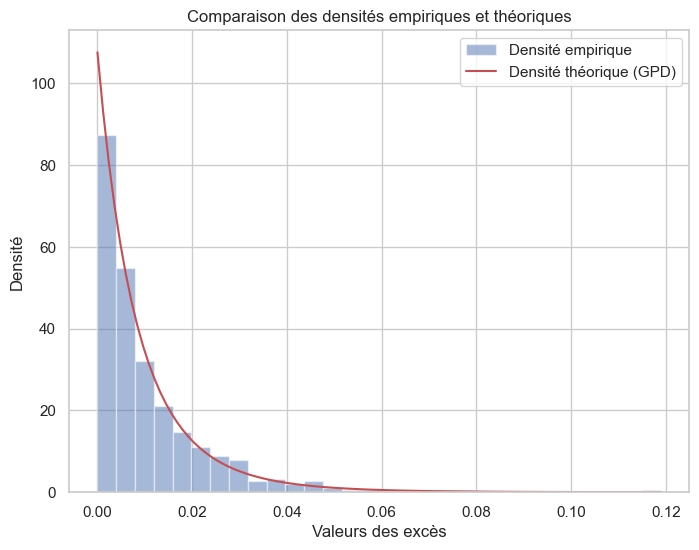

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto

def plot_gpd_diagnostics(exceedances, c, loc, scale):
    """
    Génère des graphiques pour valider l'ajustement GPD.
    
    Args:
        exceedances (pd.Series ou np.array): Les excès au-dessus du seuil.
        c (float): Paramètre de forme de la GPD.
        loc (float): Paramètre de localisation de la GPD.
        scale (float): Paramètre d'échelle de la GPD.
    """
    # 1. QQ plot (Quantile-Quantile Plot)
    theoretical_quantiles = genpareto.ppf(np.linspace(0.01, 0.99, len(exceedances)), c, loc, scale)
    empirical_quantiles = np.sort(exceedances)

    plt.figure(figsize=(8, 6))
    plt.plot(theoretical_quantiles, empirical_quantiles, marker='o', linestyle='--', color='b')
    plt.plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(theoretical_quantiles), max(theoretical_quantiles)], 'r--')
    plt.xlabel("Quantiles théoriques (GPD)")
    plt.ylabel("Quantiles empiriques")
    plt.title("QQ plot - Validation de l'ajustement GPD")
    plt.grid(True)
    plt.show()

    # 2. PP plot (Probability-Probability Plot)
    empirical_cdf = np.arange(1, len(exceedances) + 1) / len(exceedances)
    theoretical_cdf = genpareto.cdf(np.sort(exceedances), c, loc, scale)

    plt.figure(figsize=(8, 6))
    plt.plot(empirical_cdf, theoretical_cdf, marker='o', linestyle='--', color='g')
    plt.plot([0, 1], [0, 1], 'r--')  # Ligne d'identité
    plt.xlabel("CDF empirique")
    plt.ylabel("CDF théorique (GPD)")
    plt.title("PP plot - Validation de l'ajustement GPD")
    plt.grid(True)
    plt.show()

    # 3. Comparaison des densités empiriques et théoriques
    plt.figure(figsize=(8, 6))
    plt.hist(exceedances, bins=30, density=True, alpha=0.5, label="Densité empirique")

    x_vals = np.linspace(min(exceedances), max(exceedances), 100)
    pdf_theoretical = genpareto.pdf(x_vals, c, loc, scale)
    plt.plot(x_vals, pdf_theoretical, 'r-', label="Densité théorique (GPD)")

    plt.xlabel("Valeurs des excès")
    plt.ylabel("Densité")
    plt.title("Comparaison des densités empiriques et théoriques")
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns'] 
    
    # Découper les données en train/test (exemple, à adapter selon tes besoins)
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Définir le seuil (u) pour l'ajustement GPD
    threshold = 0.012
    
    # Calculer les excès
    exceedances = df_train['neg_log_returns'][df_train['neg_log_returns'] > threshold] - threshold
    
    # Ajuster la GPD sur les excès
    c, loc, scale = fit_gpd_to_exceedances(df_train, threshold)
    
    # Appeler la fonction pour afficher les graphiques de validation
    plot_gpd_diagnostics(exceedances, c, loc, scale)

if __name__ == "__main__":
    main()


## Question e
Calculer la VaR TVE par PoT sur base d’apprentissage pour alpha = 99%.

on fait d'abord le redressement du niveau de quantile :
$$ 1 - α_{POT} = \frac{n}{N_u} * (1 - α) $$
avec $N_u$ le nombre d'observations au dessus du seuil

In [ ]:
import numpy as np
import pandas as pd

def calculate_alpha_pot(df_train, exceedances, alpha):
    """
    Calcule l'alpha ajusté (alpha_pot) pour une distribution d'excès.
    
    Args:
        df_train (pd.DataFrame): DataFrame d'entraînement contenant les rendements négatifs.
        exceedances (pd.Series ou np.array): Les excès au-dessus du seuil.
        alpha (float): Le niveau de confiance pour la VaR (Value at Risk).
        
    Returns:
        float: La valeur ajustée alpha_pot.
    """
    # Calcul de alpha_pot
    alpha_pot = 1 - (len(df_train['neg_log_returns'])) / len(exceedances) * (1 - alpha)
    return alpha_pot

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']
    
    # Découper les données en train/test (exemple, à adapter selon tes besoins)
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Calculer les excès (pour cet exemple, on suppose un seuil de 0.012)
    threshold = 0.012
    exceedances = df_train['neg_log_returns'][df_train['neg_log_returns'] > threshold] - threshold
    
    # Définir le niveau de confiance
    alpha = 0.99
    
    # Appeler la fonction pour calculer alpha_pot
    alpha_pot = calculate_alpha_pot(df_train, exceedances, alpha)
    
    print(f"La valeur ajustée alpha_pot est : {alpha_pot:.4f}")

if __name__ == "__main__":
    main()


La valeur ajustée alpha_pot est : 0.9265


on calcule ensuite la VaR à l'aide de cette formule:
$$ VaR_h(α) = - H_{\hat{σ}, \hat{ξ}}^{-1} (α_{POT}) - u  $$

In [ ]:
from scipy.stats import genpareto
import pandas as pd

def calculate_var_tve_pot(alpha_pot, c, loc, scale, u):
    """
    Calcule la VaR TVE par PoT (Peak over Threshold) pour une distribution GPD ajustée.
    
    Args:
        alpha_pot (float): Le niveau de confiance ajusté (alpha_pot).
        c (float): Paramètre de forme de la distribution GPD.
        loc (float): Paramètre de localisation de la distribution GPD.
        scale (float): Paramètre d'échelle de la distribution GPD.
        u (float): Le seuil au-dessus duquel on calcule les excès.
        
    Returns:
        float: La VaR TVE par PoT calculée.
    """
    # Calcul de la VaR TVE par PoT
    var_tve_pot = -genpareto.ppf(alpha_pot, c, loc, scale) - u
    return var_tve_pot

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']
    
    # Découper les données en train/test (exemple, à adapter selon tes besoins)
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Définir le seuil (u) pour l'ajustement GPD
    threshold = 0.012
    
    # Calculer les excès (au-dessus du seuil)
    exceedances = df_train['neg_log_returns'][df_train['neg_log_returns'] > threshold] - threshold
    
    # Calculer alpha_pot
    alpha = 0.99
    alpha_pot = calculate_alpha_pot(df_train, exceedances, alpha)
    
    # Ajuster la GPD sur les excès pour obtenir les paramètres (c, loc, scale)
    c, loc, scale = fit_gpd_to_exceedances(df_train, threshold)
    
    # Calculer la VaR TVE par PoT
    var_tve_pot = calculate_var_tve_pot(alpha_pot, c, loc, scale, threshold)
    
    print(f"La VaR TVE par PoT à {alpha*100}% de confiance est : {var_tve_pot:.4f}")

if __name__ == "__main__":
    main()



La VaR TVE par PoT à 99.0% de confiance est : -0.0410


## Question f
Proposer un protocole permettant de calibrer u de manière automatique, et le mettre en œuvre

la question est assez compliquée, car normalement, on détermine le seuil u de manière graphique : on cherche à partir de quel seuil u le mean excess plot devient linéaire

perso, je veux essayer ce protocole :
-dans un premier temps, on tronque les 5% les plus extrêmes sur le mean excess plot, car le comportement est assez hératique généralement; si ce n'est pas le cas, alors la suppression ne change rien car la tendance linéaire devrait être observée plus tôt (si c'est stable)
-ensuite, le but est de trouver le seuil à partir duquel on observe une tendance linéaire
pour ce faire, je pense que nous pouvons analyser différents seuils à considérer, avec des pas faible car on travaille sur les log-rendements (on pourrait analyser tous les seuils entre 0 et le max avec la tronquature, avec un pas de 0.001)
pour chaque seuil, on essaye de tracer une tendance linéaire entre les thresholds et les valeurs du mean excess plot
ensuite, on pourrait choisir le seuil u qui permet de maximiser le R carré (car cela voudra dire que nous avons trouvé le seuil tq la droite linéaire s'ajuste le mieux aux données, ie que la relation entre le threshold et le mean excess est la plus représentative)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def find_optimal_threshold(data, step=0.001, quantile_cut=0.95):
    """
    Trouve le seuil optimal u en maximisant le R² de la tendance linéaire
    du mean excess plot.

    Args:
        data (array-like): Les données (log-rendements négatifs).
        step (float): Pas d'itération pour tester différents seuils.
        quantile_cut (float): Quantile pour tronquer les valeurs extrêmes (ex: 0.95 pour supprimer 5%).

    Returns:
        float: Le seuil optimal u.
    """

    # Tronquer les valeurs extrêmes
    max_threshold = np.quantile(data, quantile_cut)
    threshold_values = np.arange(0, max_threshold, step)

    # Calculer le mean excess plot
    mean_excesses, valid_thresholds = mean_excess_plot(data, threshold_values)

    best_r2 = -np.inf
    best_u = None

    for i, u in enumerate(valid_thresholds):
        if i < 10:  # Trop peu de points au début
            continue

        # Extraire les seuils à partir de u
        thresholds_above_u = np.array(valid_thresholds[i:])
        mean_excess_above_u = np.array(mean_excesses[i:])

        # Vérifier si assez de points pour la régression
        if len(thresholds_above_u) < 10:
            continue

        # Ajuster une régression linéaire
        X = thresholds_above_u.reshape(-1, 1)
        y = mean_excess_above_u

        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        if r2 > best_r2:
            best_r2 = r2
            best_u = u

    return best_u

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = pd.read_csv("fchi_data.csv", parse_dates=['Date'], index_col='Date')
    
    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']
    
    # Découper les données en train/test (exemple, à adapter selon tes besoins)
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
    
    # Trouver le seuil optimal
    optimal_u = find_optimal_threshold(df_train['neg_log_returns'])
    
    print(f"Seuil optimal trouvé : {optimal_u:.4f}")

if __name__ == "__main__":
    main()

#on retrouve EXACTEMENT ce qu'on avait vu par analyse graphique donc carré


Seuil optimal trouvé : 0.0120


# Cours III

VaR dynamique

comment déterminer si c'est soit un bruit blanc soit un modèle ARCH/GARCH (==> si les résidus ont un cluster de volatilité):
regarder le carré des résidus; on fait analyse ACF/PACF

Modèles Arch/GARCH
ARCH(1) :
$$ X_t =  ϵ_t * \sqrt{a + b(X_{t-1}^2)}$$

page 14 : aussi mettre la stationnarité ie somme des coeff inférieure à 1



# 8.VaR  GARCH

## Question a
Etudier l’applicabilité d’un modèle AR[1]-GARCH[1,1] à la série des log-rendements historiques sur base d’apprentissage.
On pourra procéder par étapes : plausibilité d’un AR[1], étude de l’homoscedasticité des résidus de l’AR[1]


In [ ]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# Ajustement du modèle AR(1)
ar1_model = tsa.AutoReg(df_train['log_returns'], lags=1).fit()

# Afficher les résultats
print(ar1_model.summary())


Pour la plausibilité, on regarde l'ACF (voir si on aurait pas pu prendre un ordre supérieur), et on fait le test de Ljung-Box (indépendance des résidus)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ar1_model.resid
print(residuals)

# Taille du graphique + grilles
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax)  # Ajuste le nombre de lags affichés
ax.set_title("Autocorrélation des résidus de l'AR(1)")
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

ljung_box_result = acorr_ljungbox(residuals, lags=range(1, 11), return_df=True)

print(ljung_box_result)

Une p-value élevée suggère que les résidus sont indépendants.
Ici, faible donc on rejette H0 ==> les résidus ne sont pas indépendants

Etude de l'homoscédasticité des résidus :

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title("Résidus du modèle AR(1)")
plt.show()

from statsmodels.stats.diagnostic import het_breuschpagan

test_bp = het_breuschpagan(residuals, sm.add_constant(df_train['log_returns'].shift(1).dropna()))
print(f"p-value du test de Breusch-Pagan : {test_bp[1]}")
#si pvalue faible, alors hétéro

from statsmodels.stats.diagnostic import het_arch

test_arch = het_arch(residuals)
print(f"p-value du test ARCH : {test_arch[1]}")
#si faible, pareil

#si hétéro, il faut explorer des modèles GARCH

## Question b
Estimer les paramètres du modèle AR[1]-GARCH[1,1] sur base d’apprentissage

In [ ]:
!pip install arch

In [ ]:
from arch import arch_model

# Ajustement du modèle AR(1)-GARCH(1,1)
garch_model = arch_model(df_train['log_returns'], vol='Garch', p=1, q=1, mean='AR', lags=1)
garch_result = garch_model.fit(disp='off')

print(garch_result.summary())


Modèle AR(1) (Mean Model) \
Const = 5.53e-4 → Une moyenne légèrement positive des rendements. \
AR(1) = -0.0037 (p-value = 0.845) → Le coefficient de l’AR(1) n’est pas significatif → un AR(1) seul ne semble pas pertinent. \


Modèle GARCH(1,1) (Volatility Model) \
ω (omega) = 3.87e-6 → Terme de variance constante très petit, ce qui est normal pour des rendements financiers. \
α₁ (alpha[1]) = 0.10 (p-value < 0.0001) → L’effet ARCH est significatif, indiquant une dépendance de la volatilité aux chocs passés. \
β₁ (beta[1]) = 0.88 (p-value < 0.0001) → L'effet GARCH est très fort, signifiant une forte persistance de la volatilité. \
Somme (α + β) = 0.98 → Très proche de 1, ce qui suggère une volatilité persistante mais stationnaire.

## Question intermédiaire sur l'étude du GARCH

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch

# Calcul des rendements au carré
squared_returns = df_train['log_returns'] ** 2

# Tracé de l'ACF des rendements au carré
plt.figure(figsize=(10, 5))
plot_acf(squared_returns, lags=20)
plt.title("ACF des rendements au carré")
plt.show()

# Tracé de la PACF des rendements au carré
plt.figure(figsize=(10, 5))
plot_pacf(squared_returns, lags=20, method="ywm")
plt.title("PACF des rendements au carré")
plt.show()

# Test ARCH sur les rendements
arch_test = het_arch(df_train['log_returns'])
print("Test ARCH sur les rendements:\n", arch_test)

#==> c'est bien un ARCH/GARCH et non un bruit blanc car les pics de ACF sont significatifs


## Question c
Vérifier que les résidus de l’AR[1]-GARCH[1,1] sont bien représentatifs d’un bruit blanc i.i.d. \
*Attention : les résidus fournis par le modèle nécessitent éventuellement un retraitement pour être « studentisés ».*


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extraire les résidus du modèle ajusté
residus = garch_result.resid
etiquettes = garch_result.conditional_volatility  # Volatilité conditionnelle (écart-type conditionnel)
residus_studentises = residus / etiquettes
from scipy.stats import shapiro

# Test de normalité de Shapiro-Wilk
shapiro_stat, shapiro_p_value = shapiro(residus_studentises.dropna())
print(f"Shapiro-Wilk stat: {shapiro_stat}, p-value: {shapiro_p_value}")
#si pvalue élevée alors distribution normale

from scipy.stats import jarque_bera

# Test de normalité de Jarque-Bera
jb_stat, jb_p_value = jarque_bera(residus_studentises.dropna())
print(f"Jarque-Bera stat: {jb_stat}, p-value: {jb_p_value}")



# Tracer un histogramme des résidus studentisés
plt.hist(residus_studentises, bins=30, density=True)
plt.title('Histogramme des résidus studentisés')
plt.xlabel('Valeur des résidus')
plt.ylabel('Densité')
plt.show()

#Tracer les résidus studentisés au cours du temps
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residus_studentises)
plt.title('Résidus studentisés au cours du temps')
plt.xlabel('Temps')
plt.ylabel('Résidus studentisés')

# Tracer la volatilité conditionnelle (écart-type conditionnel) au cours du temps
plt.subplot(2, 1, 2)
plt.plot(etiquettes)
plt.title('Volatilité conditionnelle (écart-type) au cours du temps')
plt.xlabel('Temps')
plt.ylabel('Volatilité conditionnelle')

plt.tight_layout()
plt.show()

## Question d
Reproduire la dynamique historique de $μ_t$ et $σ_t$ selon la dynamique et les valeurs initiales fournies dans le support de cours (cours III slide 18) sur l’ensemble de la période (apprentissage + test).

*Principe :* Estimation d’une VaR en $t + 1$ à partir de l’ensemble des informations disponibles en $t$, et de l’estimation des paramètres du modèle :

\begin{equation}
\left\{
\begin{aligned}
\widehat{\mu}_{t+1} &= \widehat{\mu} + \widehat{\varphi} r_t \\
\widehat{\sigma}^2_{t+1} &= \omega + \alpha (\widehat{r}_t - \widehat{\mu}_t)^2 + \beta \widehat{\sigma}^2_t
\end{aligned}
\right.
\end{equation}

*Nécessité d’initialiser la première valeur des volatilités :* on utilise la variance long terme :
$
\frac{1}{\omega - \alpha - \beta}
$

$$
\mu_1 = \widehat{\mu}, \quad \sigma_1 = \sqrt{\frac{1}{\omega - \alpha - \beta}}
$$

*Calcul :* En notant $q_{1-\alpha}$ le quantile de niveau $1 - \alpha$ des résidus $\varepsilon_t$, on a :

$$
\text{VaR}_{h,t+1}^\alpha = \widehat{\mu}_{t+1} + \widehat{\sigma}_{t+1} \times q_{1-\alpha} = \widehat{\mu} + \widehat{\varphi} r_t + \widehat{\omega} + q_{1-\alpha} \times \sqrt{\widehat{a} (r_t - \widehat{\mu}_t)^2 + \widehat{b} \widehat{\sigma}^2_t}
$$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fusionner les datasets d'apprentissage et de test
df_complete = pd.concat([df_train, df_test])

# Récupération des paramètres estimés du modèle AR(1)-GARCH(1,1)
mu_hat = garch_result.params['Const']
print(mu_hat)
phi_hat = garch_result.params['log_...rns[1]']
print(phi_hat)
omega_hat = garch_result.params['omega']
alpha_hat = garch_result.params['alpha[1]']
beta_hat = garch_result.params['beta[1]']

# Initialisation des valeurs de mu et sigma selon les formules du support
mu_1 = mu_hat
sigma_1 = np.sqrt(omega_hat / (1 - alpha_hat - beta_hat))

# Initialiser les listes pour stocker les valeurs
mu_t = [mu_1]
sigma_t = [sigma_1]

# Récupérer les rendements de la série complète
returns = df_complete['log_returns'].values

# Boucle pour calculer mu_t et sigma_t sur toute la période
for t in range(len(returns) - 1):
    mu_next = mu_hat + phi_hat * returns[t]
    sigma_next = np.sqrt(omega_hat + alpha_hat * (returns[t] - mu_t[-1])**2 + beta_hat * sigma_t[-1]**2)

    mu_t.append(mu_next)
    sigma_t.append(sigma_next)

# Ajouter les résultats au DataFrame
df_complete = df_complete.copy()
df_complete['mu_t'] = mu_t
df_complete['sigma_t'] = sigma_t

# Tracer l'évolution de mu_t et sigma_t
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df_complete.index, df_complete['mu_t'], label='μ_t', color='blue')
plt.title("Évolution de μ_t")
plt.xlabel("Temps")
plt.ylabel("μ_t")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_complete.index, df_complete['sigma_t'], label='σ_t', color='red')
plt.title("Évolution de σ_t")
plt.xlabel("Temps")
plt.ylabel("σ_t")
plt.legend()

plt.tight_layout()
plt.show()

#pb de mu_t constant


## Question e
Pour 2 méthodes de calcul de VaR de son choix parmi 1 méthode « classique » (historique, gaussienne, skew Student) et 1 méthode TVE (BM, POT) : \
i.	Estimer la VaR sur les résidus \
ii.	Calculer la VaR dynamique et les exceptions associées sur la base de test


### Question i.

In [ ]:
print(residus_studentises.dropna())

In [ ]:
alpha = 0.99
var_train = VaR_Hist(residus_studentises, alpha)
print(f"VaR historique (niveau de confiance de {alpha*100:.0f}%) sur les données d'apprentissage : {var_train}")

In [ ]:
import numpy as np
from scipy.stats import genextreme

# Transformer en opposé pour inverser la queue de distribution
neg_residus = -residus_studentises

# Définir des blocs temporels (par mois)
months = residus_studentises.index.to_period('M')

# Créer un DataFrame temporaire pour grouper les données
df_temp = pd.DataFrame({'neg_residus': neg_residus, 'month': months})

# Extraire le maximum par bloc
block_maxima_residus = df_temp.groupby('month')['neg_residus'].max()

# Ajuster la loi GEV aux maxima de blocs
c_residus, loc_residus, scale_residus = genextreme.fit(block_maxima_residus)

# Calcul de la VaR TVE
alpha = 0.99
alpha_bm = alpha**21
var_tve_residus = genextreme.ppf(alpha_bm, c=c_residus, loc=loc_residus, scale=scale_residus)

print(f"La VaR TVE à {alpha*100}% de confiance est : {-var_tve_residus:.4f}")


### Question ii.

In [ ]:
# Filtrer les données à partir du 2022-07-27
df_test = df_complete[df_complete.index >= '2022-07-27']

# Calcul de la VaR dynamique
q_alpha = -var_tve_residus
df_test['VaR_t'] = df_test['mu_t'] + df_test['sigma_t'] * q_alpha

# Tracer l'évolution de la VaR dynamique avec les rendements
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test['log_returns'], label='Rendements', color='blue', alpha=0.6)
plt.plot(df_test.index, df_test['VaR_t'], label='VaR_t', color='red')
plt.title("Évolution de la VaR Dynamique et des Rendements")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.grid()
plt.show()

# Tracer les rendements sur tout df_complete
plt.figure(figsize=(12, 6))
plt.plot(df_complete.index, df_complete['log_returns'], label='Rendements', color='blue', alpha=0.6)

# Ajouter une ligne verticale en pointillés pour la séparation train/test
split_date = '2022-07-27'
plt.axvline(pd.to_datetime(split_date), color='black', linestyle='dashed', label='Séparation Train/Test')

# Tracer la VaR après la date de séparation
plt.plot(df_test.index, df_test['VaR_t'], label='VaR_t', color='red')

# Ajouter les titres et légendes
plt.title("Rendements et VaR Dynamique avec séparation Train/Test")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.grid()

# Afficher le graphique
plt.show()


In [ ]:
# Calcul des exceptions : lorsque les rendements sont inférieurs à la VaR dynamique
df_test['exceptions'] = df_test['log_returns'] < df_test['VaR_t']

# Afficher le nombre d'exceptions
nombre_exceptions = df_test['exceptions'].sum()
print(f"Nombre d'exceptions à partir du 2022-07-27 : {nombre_exceptions}")